In [50]:
import os
import torch
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from torch.autograd import Variable
from matplotlib.pyplot import figure
pd.options.mode.chained_assignment = None

In [51]:
data_folder = 'router_experiments_data/priority_in_tgis_6.6.6_op_60/tgis/'

tgi_columns = ['timestamp', 'job', "namespace", "pod", "value", "user"]
tgi_merge_columns = ['timestamp', 'job', "namespace", "pod", "user"]

tgi_queue_columns = ['timestamp', 'job', "namespace", "pod", "value"]
tgi_queue_merge_columns = ['timestamp', 'job', "namespace", "pod"]

In [52]:
import urllib3
urllib3.disable_warnings()

In [53]:
def get_tgi_metrics(metric_name, columns, filter_pod):
    files = os.listdir(data_folder)
    dataframes = []
    for i in files:
        if i[:len(metric_name)] == metric_name:
            temp = pd.read_csv(f'{data_folder}{i}')
            temp = temp[columns]
            dataframes.append(temp)
    result = pd.concat(dataframes)
    for key in filter_pod:
        result = result[result[key].isin(filter_pod[key])]
    result.drop_duplicates(inplace=True)
    return result.reset_index(drop=True)

def get_router_metrics(metric_name, columns, filter_pod):
    files = os.listdir(data_folder)
    dataframes = []
    for i in files:
        if i[:len(metric_name)] == metric_name:
            temp = pd.read_csv(f'{data_folder}{i}')
            temp = temp[columns]
            dataframes.append(temp)
    result = pd.concat(dataframes)
    for key in filter_pod:
        result = result[result[key].isin(filter_pod[key])]
    result.drop_duplicates(inplace=True)
    return result.reset_index(drop=True)

In [54]:
def get_tgi_df(metrics, tgi_columns, tgi_merge_columns, tgi_filter):
    tgi_df = get_tgi_metrics(metrics[0], tgi_columns, tgi_filter)
    tgi_df.rename(columns={"value":metrics[0]}, inplace=True)
    for metric in metrics[1:]:
        temp_df = get_tgi_metrics(metric, tgi_columns, tgi_filter)
        tgi_df = pd.merge(tgi_df, temp_df, on = tgi_merge_columns)
        tgi_df.rename(columns={"value":metric}, inplace=True)
    return tgi_df
def get_router_df(metrics, router_columns, router_merge_columns, router_filter):
    router_df = get_router_metrics(metrics[0], router_columns, router_filter)
    router_df.rename(columns={"value":metrics[0]}, inplace=True)
    for metric in metrics[1:]:
        temp_df = get_router_metrics(metric, router_columns, router_filter)
        router_df = pd.merge(router_df, temp_df, on = router_merge_columns)
        router_df.rename(columns={"value":metric}, inplace=True)
    return router_df

def clean_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df.reset_index(inplace=True, drop=True)
    return df

In [55]:
tgi_metrics = [
    "tgi_request_duration_sum",
    "tgi_request_duration_count"
]

tgi_queue = [
    "tgi_request_queue_duration_count",
    "tgi_request_queue_duration_sum"
]

tgi_filter = {'pod':['llama3-priority']}

In [56]:
batch_size = clean_data(get_tgi_df(["tgi_batch_current_size"], ['timestamp', 'job', "namespace", "pod", "value"], ['timestamp', 'job', "namespace", "pod"], tgi_filter))
batch_size.reset_index(inplace=True, drop=True)

In [57]:
tgi_request_count = clean_data(get_tgi_df(["tgi_request_duration_count"], ['timestamp', 'job', "namespace", "pod", "value","user"], ['timestamp', 'job', "namespace", "pod", "user"], tgi_filter))
tgi_request_count.dropna(inplace=True)
for user in tgi_request_count['user'].unique():
    tmp = tgi_request_count[tgi_request_count['user'] == user]
    tmp.reset_index(inplace=True, drop=True)
    q_count = tmp['tgi_request_duration_count'][tmp.shape[0]-1] - tmp['tgi_request_duration_count'][0]
    duration = (tmp['timestamp'][tmp.shape[0]-1] - tmp['timestamp'][0]).seconds
    request_rate = q_count / duration
    print(f"Questions for user : {user} : {q_count} : Duration : {duration} : Request Rate : {request_rate}")

Questions for user : Alan : 1288.0 : Duration : 2275 : Request Rate : 0.5661538461538461
Questions for user : Hari : 384.0 : Duration : 2275 : Request Rate : 0.1687912087912088
Questions for user : Noel : 1198.0 : Duration : 2275 : Request Rate : 0.5265934065934066


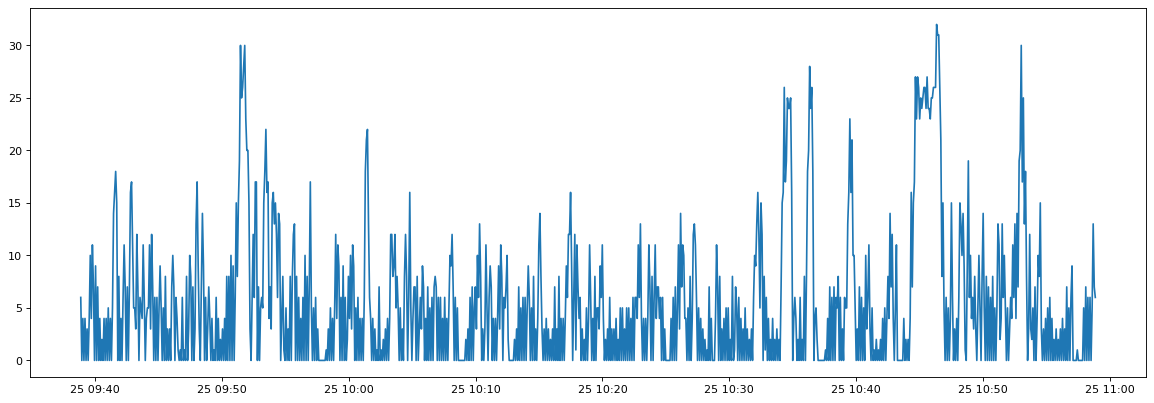

In [15]:
figure(figsize=(18, 6), dpi=80)
plt.plot(batch_size['timestamp'], batch_size['tgi_batch_current_size'])

In [58]:
tgi_df = clean_data(get_tgi_df(tgi_metrics, tgi_columns, tgi_merge_columns, tgi_filter))
tgi_queue_df = clean_data(get_tgi_df(tgi_queue, tgi_queue_columns, tgi_queue_merge_columns, tgi_filter))

In [59]:
tgi_df

,timestamp,job,namespace,pod,tgi_request_duration_sum,user,tgi_request_duration_count
0,2024-07-17 09:01:00.401000023,tgis-bam,fmaas-monitoring,llama3-priority,56.937024,Alan,7.0
1,2024-07-17 09:01:00.401000023,tgis-bam,fmaas-monitoring,llama3-priority,116.369569,Hari,12.0
2,2024-07-17 09:01:00.401000023,tgis-bam,fmaas-monitoring,llama3-priority,110.216408,Noel,9.0
3,2024-07-17 09:01:05.410000086,tgis-bam,fmaas-monitoring,llama3-priority,110.216408,Noel,9.0
4,2024-07-17 09:01:05.410000086,tgis-bam,fmaas-monitoring,llama3-priority,108.322278,Alan,9.0
...,...,...,...,...,...,...,...
1363,2024-07-17 09:38:50.401000023,tgis-bam,fmaas-monitoring,llama3-priority,59017.661650,Noel,1207.0
1364,2024-07-17 09:38:50.401000023,tgis-bam,fmaas-monitoring,llama3-priority,77773.009027,Hari,395.0
1365,2024-07-17 09:38:55.401000023,tgis-bam,fmaas-monitoring,llama3-priority,40540.721685,Alan,1295.0
1366,2024-07-17 09:38:55.401000023,tgis-bam,fmaas-monitoring,llama3-priority,77954.737645,Hari,396.0


In [60]:
tgi_queue_df

,timestamp,job,namespace,pod,tgi_request_queue_duration_count,tgi_request_queue_duration_sum
0,2024-07-17 09:01:00.401000023,tgis-bam,fmaas-monitoring,llama3-priority,54.0,146.227611
1,2024-07-17 09:01:05.410000086,tgis-bam,fmaas-monitoring,llama3-priority,56.0,167.554869
2,2024-07-17 09:01:10.401000023,tgis-bam,fmaas-monitoring,llama3-priority,63.0,268.020739
3,2024-07-17 09:01:15.401000023,tgis-bam,fmaas-monitoring,llama3-priority,71.0,328.157905
4,2024-07-17 09:01:20.538000107,tgis-bam,fmaas-monitoring,llama3-priority,86.0,579.742368
...,...,...,...,...,...,...
451,2024-07-17 09:38:35.401000023,tgis-bam,fmaas-monitoring,llama3-priority,2919.0,105882.966294
452,2024-07-17 09:38:40.401000023,tgis-bam,fmaas-monitoring,llama3-priority,2934.0,107840.079500
453,2024-07-17 09:38:45.401000023,tgis-bam,fmaas-monitoring,llama3-priority,2940.0,107858.571828
454,2024-07-17 09:38:50.401000023,tgis-bam,fmaas-monitoring,llama3-priority,2946.0,108730.115992


In [61]:
df = tgi_df

In [62]:
def plot_histogram(arry, feature_name, user, bucket_number=100):
    arry = arry[~np.isnan(arry)]
    arry = sorted(arry)
    bucket_size = max((max(arry) - min(arry)) // bucket_number, 1)
    b = 0
    buckets = {}
    while b <= max(arry):
        buckets[b] = 0
        b += bucket_size
    for i in arry:
        buckets[i - i % bucket_size] += 1
    
    cdf = {}
    count = len(arry)
    s = 0
    for i in buckets:
        cdf[i] = (s + buckets[i]) / count
        s += buckets[i]
    
    fig, axs = plt.subplots(2)
    
    axs[0].bar(buckets.keys(), buckets.values(), align='center', width = 8)
    axs[0].set_title(f"Histogram of {feature_name} for {user}")
    axs[0].set(xlabel=f'{feature_name} - bucket size {bucket_size} seconds')
    
    axs[1].plot(cdf.keys(), cdf.values())
    axs[1].set_title(f"CDF of {feature_name} for {user}")
    axs[1].set(xlabel=f'{feature_name} - cumulative distribution function')
    
    plt.subplots_adjust(bottom=0.5, top=2)
def get_user_features(data):
    for user in data['user'].unique():
        print(f"User : {user}")
        tmp = data[data['user'] == user]
        tmp['latency'] = tmp['tgi_request_duration_sum'].diff() / tmp['tgi_request_duration_count'].diff()
        print(f"    Mean Latency : {tmp['latency'].mean()}")
        plot_histogram(tmp['latency'], "Latency", user)
def get_overall_features(data):
    latency = np.array([])
    queue_time = np.array([])
    for user in data['user'].unique():
        tmp = data[data['user'] == user]
        tmp['latency'] = tmp['tgi_request_duration_sum'].diff() / tmp['tgi_request_duration_count'].diff()
        latency = np.concatenate([latency,np.array(tmp['latency'])])
    latency = latency[~np.isnan(latency)]
    print(f"    Overall Mean Latency : {latency.mean()}")
    plot_histogram(latency, "Latency", "overall")
def get_queue_features(data):
    queue = data['tgi_request_queue_duration_sum'].diff() / data['tgi_request_queue_duration_count'].diff()
    queue = queue[~np.isnan(queue)]
    print(f"    Overall Mean Queue time : {queue.mean()}")
    plot_histogram(queue, "Queue Time", "overall")

User : Alan
    Mean Latency : 31.207004913231486
User : Hari
    Mean Latency : 223.43362166131672
User : Noel
    Mean Latency : 48.71434299817475


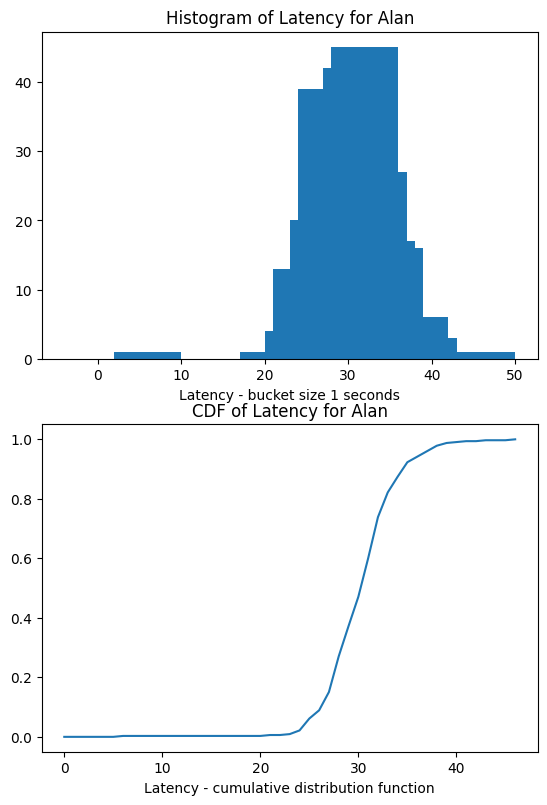

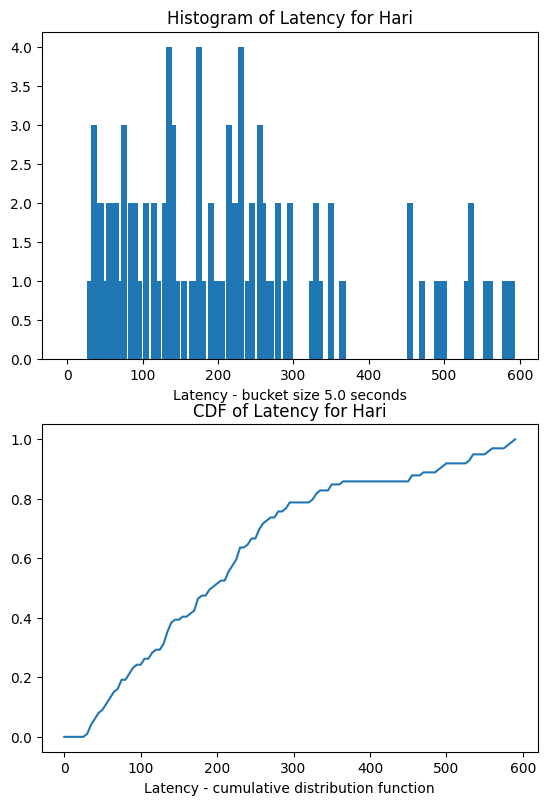

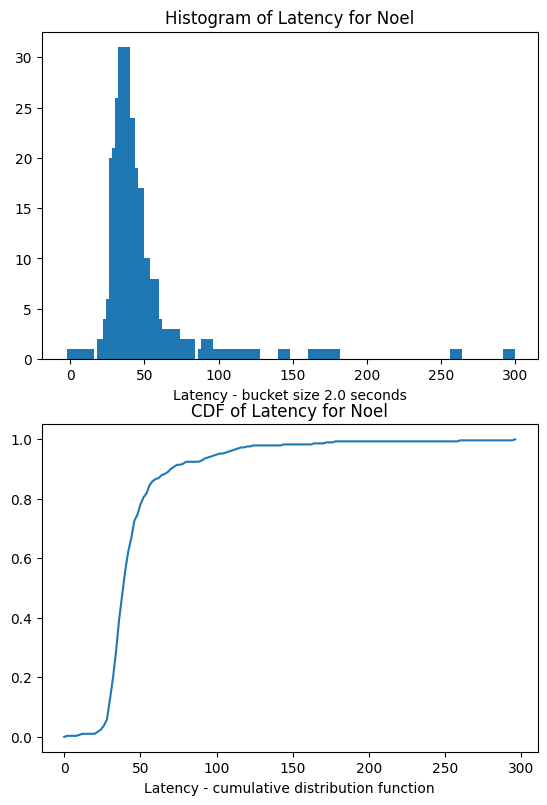

In [63]:
get_user_features(df.dropna())

    Overall Mean Latency : 159.79527926385117


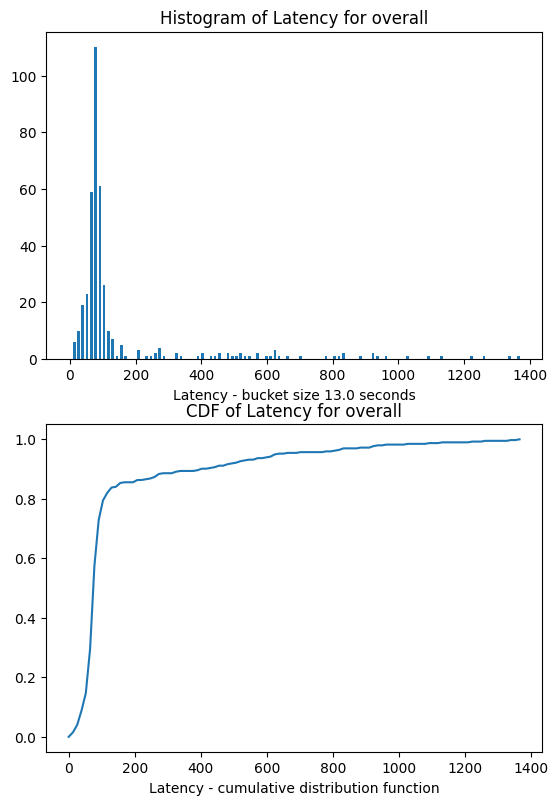

In [49]:
get_overall_features(df.dropna())

    Overall Mean Queue time : 149.0993245287809


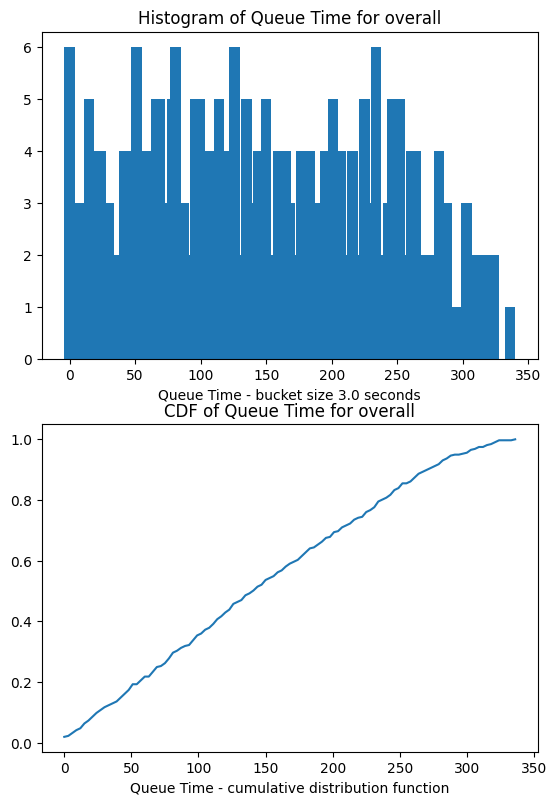

In [34]:
get_queue_features(tgi_queue_df.dropna())